# exploratory data analysis

In [1]:
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pylab
from pylab import *
import numpy as np
from skimage import measure
from skimage.transform import resize

from config import *

## Target distribution

In [2]:
df_targets = pd.read_csv(TARGET_LABELS_DATA_PATH)
df_targets.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Number of rows in auxiliary dataset: 28989
Number of unique patient IDs: 25684


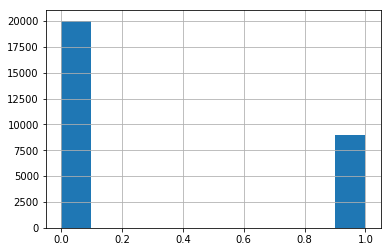

In [3]:
df_targets.Target.hist()
print('Number of rows in auxiliary dataset:', df_targets.shape[0])
print('Number of unique patient IDs:', df_targets['patientId'].nunique())
plt.show()

In [4]:
df_classes = pd.read_csv(DETAILED_CLASS_INFO_DATA_PATH)
df_classes.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


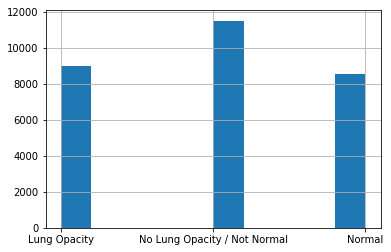

In [5]:
df_classes['class'].hist()
plt.show()

In [6]:
assert df_targets['patientId'].values.tolist() == df_classes['patientId'].values.tolist(), 'PatientId columns are different.'
df_train = pd.concat([df_targets, df_classes.drop(labels=['patientId'], axis=1)], axis=1)
df_train.head(6)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity


In [7]:
pId = df_targets['patientId'].sample(1).values[0]    
dcmdata = pydicom.read_file(TRAIN_IMAGES_PATH + pId + '.dcm')
print(dcmdata)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.14977.1517874382.871680
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '78de87af-368f-4821-985b-c21d83392e5f'
(0010, 0020) Patient ID                          LO: '78de87af-368f-4821-985b-c21d83392e5f'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [8]:
def get_boxes_per_patient(df, pId):
    '''
    Given the dataset and one patient ID, 
    return an array of all the bounding boxes and their labels associated with that patient ID.
    Example of return: 
    array([[x1, y1, width1, height1, class1, target1],
           [x2, y2, width2, height2, class2, target2]])
    '''
    
    boxes = df.loc[df['patientId']==pId][['x', 'y', 'width', 'height', 'class', 'Target']].values
    return boxes


In [9]:
def get_dcm_data_per_patient(pId, sample='train'):
    '''
    Given one patient ID and the sample name (train/test), 
    return the corresponding dicom data.
    '''
    return pydicom.read_file(DATA_FOLDER_PATH+'stage_1_'+sample+'_images/'+pId+'.dcm')

In [10]:
def display_image_per_patient(df, pId, angle=0.0, sample='train'):
    '''
    Given one patient ID and the dataset,
    display the corresponding dicom image with overlaying boxes and class annotation.
    To be implemented: Optionally input the image rotation angle, in case of data augmentation.
    '''
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    dcmimg = dcmdata.pixel_array
    boxes = get_boxes_per_patient(df, pId)
    plt.figure(figsize=(14,7))
    plt.imshow(dcmimg, cmap=pylab.cm.binary)
    plt.axis('off')
    
    class_color_dict = {'Normal' : 'green',
                        'No Lung Opacity / Not Normal' : 'orange',
                        'Lung Opacity' : 'red'}

    if len(boxes)>0:
        for box in boxes:
            # extracting individual coordinates and labels
            x, y, w, h, c, t = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', 
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            plt.gca().add_patch(patch)
            
    # add annotation text
    plt.text(10, 50, c, color=class_color_dict[c], size=20, 
             bbox=dict(edgecolor=class_color_dict[c], facecolor='none', alpha=0.5, lw=2))
    plt.show()

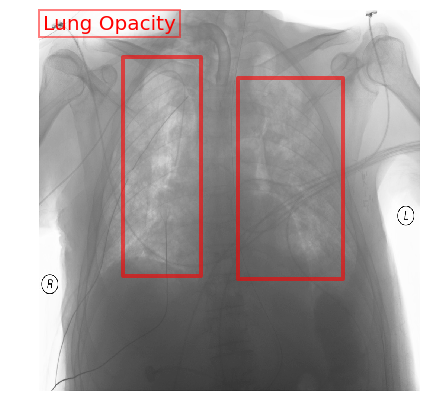

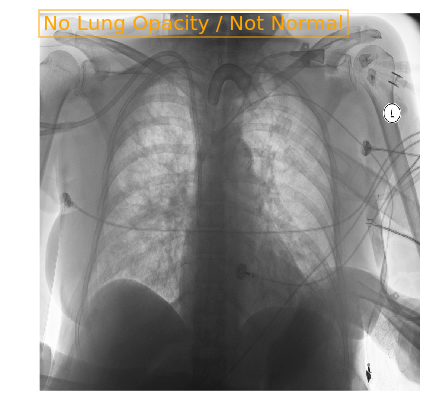

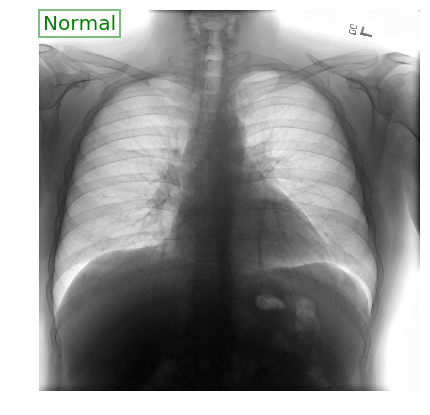

In [11]:
## get a sample from each class
samples = df_train.groupby('class').apply(lambda x: x.sample(1))['patientId']

for pId in samples.values:   
    display_image_per_patient(df_train, pId, sample='train')

### Extract useful meta-data from dicom headers

In [12]:
def get_metadata_per_patient(pId, attribute, sample='train'):
    '''
    Given a patient ID, return useful meta-data from the corresponding dicom image header.
    Return: 
    attribute value
    '''
    # get dicom image
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    # extract attribute values
    attribute_value = getattr(dcmdata, attribute)
    return attribute_value

In [13]:
df_train = df_train.sample(2000)
# create list of attributes that we want to extract (manually edited after checking which attributes contained valuable information)
attributes = ['PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    df_train[a] = df_train['patientId'].apply(lambda x: get_metadata_per_patient(x, a, sample='train'))
# convert patient age from string to numeric
df_train['PatientAge'] = df_train['PatientAge'].apply(pd.to_numeric, errors='coerce')
# remove a few outliers
df_train['PatientAge'] = df_train['PatientAge'].apply(lambda x: x if x<120 else np.nan)
df_train.head()

,patientId,x,y,width,height,Target,class,PatientSex,PatientAge,ViewPosition
1518,1699f1aa-36a9-40c9-95f7-da12c7927f15,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,60,AP
17087,a4146511-3e5e-4663-a79a-d0b578aca940,246.0,323.0,224.0,502.0,1,Lung Opacity,F,74,AP
24387,db24add4-558e-4ad6-9f79-a3d78ff786bf,NaN,NaN,NaN,NaN,0,Normal,F,41,PA
16160,9cb5bc5f-4ac5-4da9-9d67-7d52fd67bc10,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,M,49,PA
7201,550a9dba-aed6-4716-afdb-72d87315ea8b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,M,70,PA


### Gender Distribution

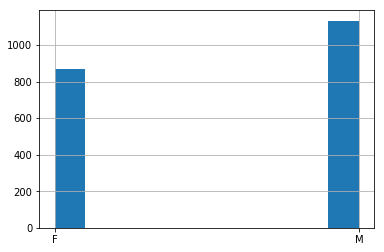

In [14]:
df_train.PatientSex.hist()
plt.show()

### Age Distribution

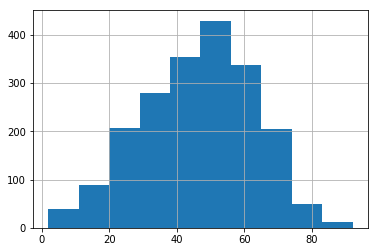

In [15]:
df_train.PatientAge.hist()
plt.show()

In [16]:
# empty dictionary
pneumonia_locations = {}

for _, row in df_targets.iterrows():
    # retrieve information
    filename = row[0]
    location = row[1:5]
    pneumonia = row[5]
    # if row contains pneumonia add label to dictionary
    # which contains a list of pneumonia locations per filename
    if pneumonia == '1':
        # convert string to float to int
        location = [int(float(i)) for i in location]
        # save pneumonia location in dictionary
        if filename in pneumonia_locations:
            pneumonia_locations[filename].append(location)
        else:
            pneumonia_locations[filename] = [location]

In [17]:
ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

ValueError: zero-size array to reduction operation maximum which has no identity